In [362]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Download dataset

In [2]:
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


# !curl -L -o ./time-series-datasets.zip https://www.kaggle.com/api/v1/datasets/download/shenba/time-series-datasets
# !unzip ./time-series-datasets.zip

[Reference](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)
- `store_nbr` identifies the store at which the products are sold.
- `family` identifies the type of product sold.
- `sales` gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- `onpromotion` gives the total number of items in a product family that were being promoted at a store at a given date.

In [3]:
# predict sales
!kaggle competitions download -c store-sales-time-series-forecasting
!unzip /content/store-sales-time-series-forecasting.zip

  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 901MB/s]
Archive:  /content/store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [5]:
df = pd.read_csv('/content/train.csv')
# df_hol = pd.read_csv('/content/holidays_events.csv')
# df_oil = pd.read_csv('/content/oil.csv')
# df_sub = pd.read_csv('/content/sample_submission.csv')
# df_store = pd.read_csv('/content/stores.csv')
# df_trans = pd.read_csv('/content/transactions.csv')
# df_test = pd.read_csv('/content/test.csv')

df.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [44]:
df.isna().sum() / len(df) * 100

,0
id,0.0
date,0.0
store_nbr,0.0
family,0.0
sales,0.0
onpromotion,0.0


## Manipulate time series

[Time series](https://pandas.pydata.org/docs/user_guide/timeseries.html)

[kaggle](https://www.kaggle.com/learn/time-series)

- pandas captures 4 general time related concepts:

1. Date times: A specific date and time with timezone support. Similar to `datetime.datetime` from the standard library.
2. Time deltas: An absolute time duration. Similar to `datetime.timedelta` from the standard library.
3. Time spans: A span of time defined by a point in time and its associated frequency.
4. Date offsets: A relative time duration that respects calendar arithmetic. Similar to `dateutil.relativedelta.relativedelta` from the `dateutil` package.

> pandas represents null date times, time deltas, and time spans as `NaT`

<br>

### Set data columns as Index When:

- You're doing time series analysis

- You need to resample data (daily, monthly, etc.)

- You're frequently filtering/slicing by time

- You want to use time-based operations

In [45]:
day = pd.Timestamp("2023-01-03")
print(day.day_name())

next_day  = day + pd.Timedelta('1 day')
print(next_day.day_name())

Tuesday
Wednesday


In [ ]:
# 'coerce': Convert invalid to NaT
# 'ignore': Leave invalid as-is
# format="%d-%m-%Y %H:%M"
df['date'] = pd.to_datetime(df['date'], errors = 'coerce', format = '%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [97]:
# Specify date column when reading data
df = pd.read_csv('/content/train.csv', parse_dates = ['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [9]:
# df = df.set_index('date')
df = pd.read_csv('/content/train.csv', parse_dates = ['date'], index_col = 'date')
df.head(5)

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [121]:
# pd.api.types.is_datetime64_any_dtype(df.index)

In [125]:
df.index.min(), df.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

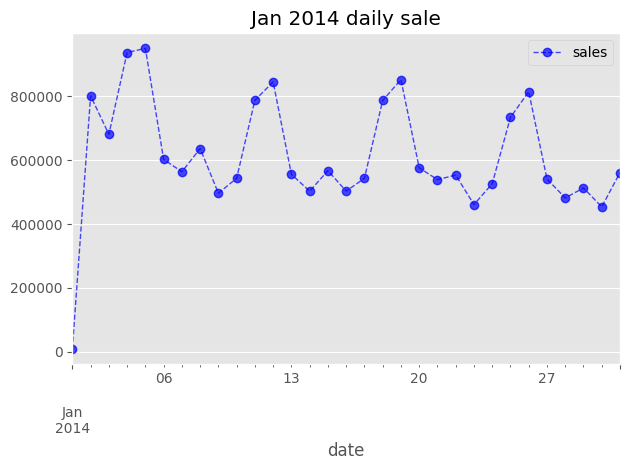

In [36]:
# We want to plot a specific month sales
jan_2014 = df[(df.index.year == 2014) & (df.index.month == 1)]
daily_sale = jan_2014.groupby(jan_2014.index)['sales'].sum()

plt.style.use('ggplot')
daily_sale.plot(
    marker = 'o', linestyle = '--', alpha = 0.7, linewidth = 1, color = 'blue', title = 'Jan 2014 daily sale'
)

plt.tight_layout()
plt.legend()
plt.show()

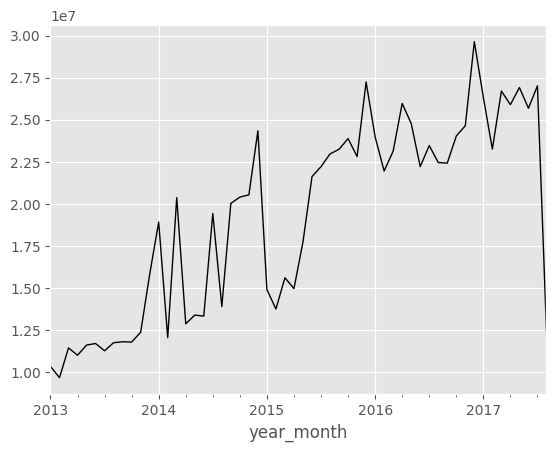

In [42]:
# Create month-year period for grouping
df['year_month'] = df.index.to_period('M') # h, D, W, M, y
df.groupby('year_month')['sales'].sum().plot(linewidth = 1, color = 'black')
plt.show()

In [43]:
# Monthly aggregation
monthly_stats = df.groupby('year_month').agg({
    'sales': ['sum', 'mean', 'count'],
    'onpromotion': 'sum'
}).round(2)

monthly_stats.columns = ['total_sales', 'avg_sales', 'transaction_count', 'total_promotions']
monthly_stats.reset_index()
monthly_stats.head()

,total_sales,avg_sales,transaction_count,total_promotions
year_month,,,,
2013-01,10327624.74,186.95,55242,0
2013-02,9658959.78,193.58,49896,0
2013-03,11428497.04,206.88,55242,0
2013-04,10993464.74,205.64,53460,0
2013-05,11597704.01,209.94,55242,0


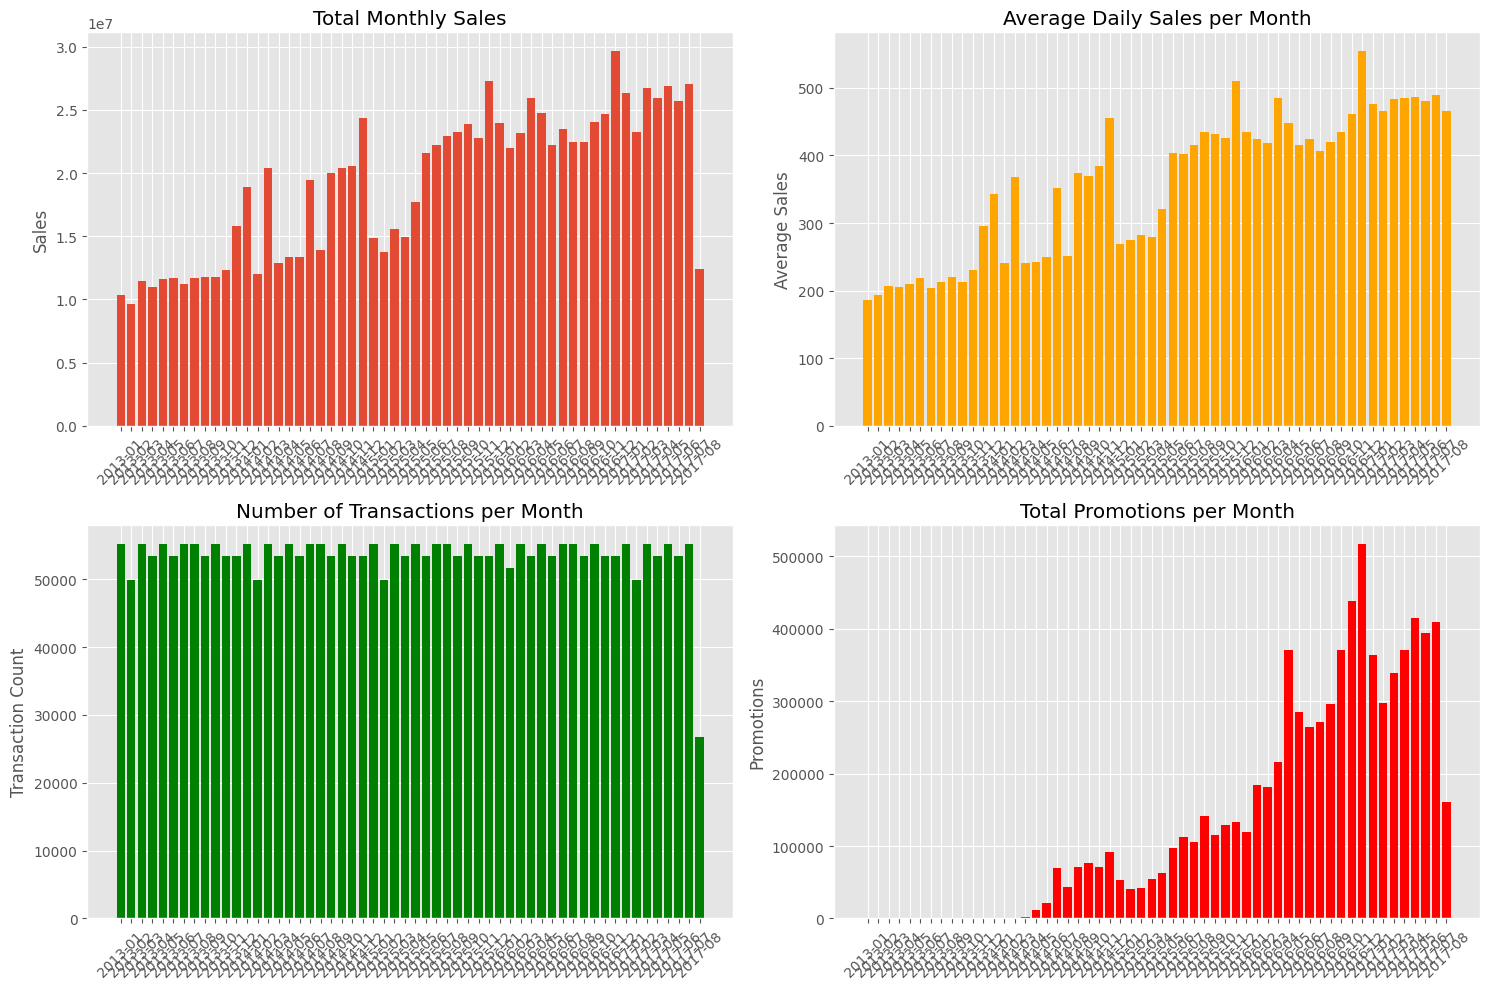

In [45]:
monthly_stats['year_month_str'] = monthly_stats.index.astype(str)

# Plot monthly comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total sales by month
axes[0,0].bar(monthly_stats['year_month_str'], monthly_stats['total_sales'])
axes[0,0].set_title('Total Monthly Sales')
axes[0,0].set_ylabel('Sales')
axes[0,0].tick_params(axis='x', rotation=45)

# Average sales by month
axes[0,1].bar(monthly_stats['year_month_str'], monthly_stats['avg_sales'], color='orange')
axes[0,1].set_title('Average Daily Sales per Month')
axes[0,1].set_ylabel('Average Sales')
axes[0,1].tick_params(axis='x', rotation=45)

# Transaction count
axes[1,0].bar(monthly_stats['year_month_str'], monthly_stats['transaction_count'], color='green')
axes[1,0].set_title('Number of Transactions per Month')
axes[1,0].set_ylabel('Transaction Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Promotions
axes[1,1].bar(monthly_stats['year_month_str'], monthly_stats['total_promotions'], color='red')
axes[1,1].set_title('Total Promotions per Month')
axes[1,1].set_ylabel('Promotions')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Moving average plot

To see what kind of trend a time series might have. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

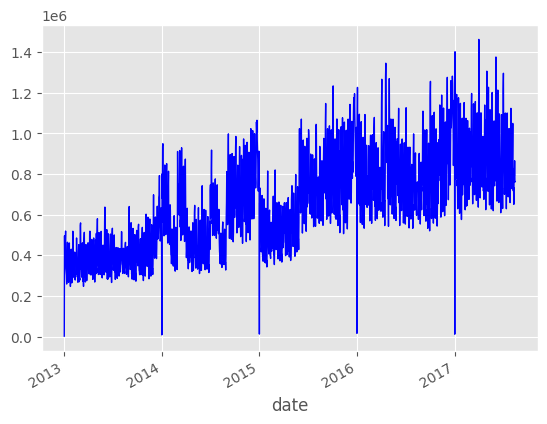

In [367]:
# since the index in daily we don't need a new column to groupby that
daily_stats = df.groupby(df.index).agg(
    {
        'sales': ['sum', 'mean', 'count']
    }
)

daily_stats.columns = ['total_sales', 'avg_sales', 'sales_count']
daily_stats['total_sales'].plot(color = 'blue', linewidth = 1)
plt.show()

In [368]:
moving_average = daily_stats.rolling(
    window = 30,        # 30-day window
    center = True,      # puts the average at the center of the window
    min_periods = 15,   # choose about half the window size
).mean()

moving_average.head()

,total_sales,avg_sales,sales_count
date,,,
2013-01-01,345177.747714,193.702440,1782.0
2013-01-02,343500.883104,192.761438,1782.0
2013-01-03,339030.155626,190.252613,1782.0
2013-01-04,336646.860870,188.915186,1782.0
2013-01-05,341689.649878,191.745034,1782.0


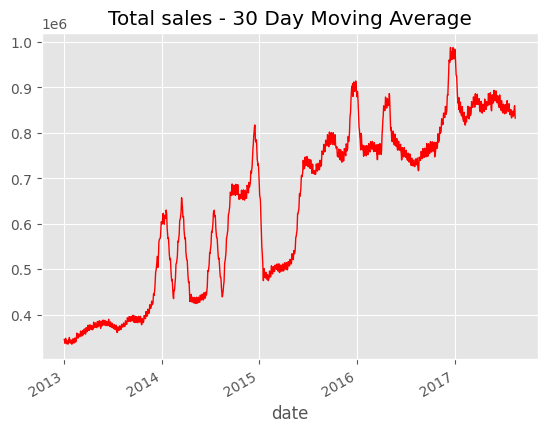

In [369]:
moving_average['total_sales'].plot(color = 'red', linewidth = 1, title = "Total sales - 30 Day Moving Average")
plt.show()

### Seasonality
We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series.

We will learn two kinds of features that model seasonality
- The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations.
- The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

#### **Seasonal Plots and Seasonal Indicator**

Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

- A **seasonal plot** shows segments of the time series plotted against some common period, the period being the "season" you want to observe.
- **Seasonal indicators** are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

> By one-hot encoding days of the week, we get weekly seasonal indicators, Linear regression works best if you drop one of the indicators.

In [374]:
def seasonal_plot(X, y, period, freq):
    plt.figure(figsize=(11, 5))

    palette = sns.color_palette("husl", n_colors = X[period].nunique())

    sns.lineplot(
        x = freq, # how long is should show
        y = y,
        hue = period, # split data in years for example
        data = X,
        errorbar = ('ci', False),
        palette = palette,
        linewidth = 1
    )

    plt.title(f"Seasonal Plot ({period}/{freq})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    return plt

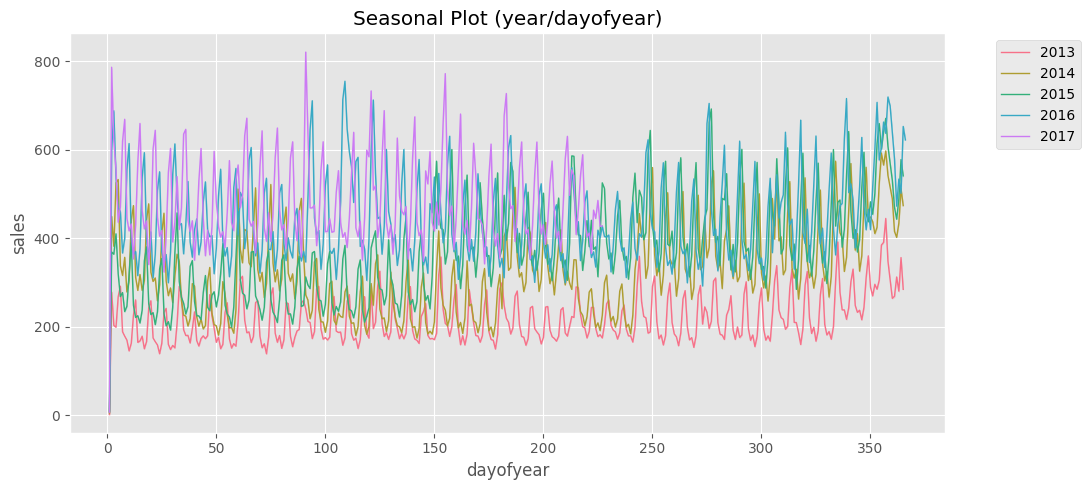

In [375]:
X = df.copy()

X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.isocalendar().week # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

# seasonal_plot(X, y='sales', period='week', freq='day')
seasonal_plot(X, y = 'sales', period = 'year', freq = 'dayofyear')
plt.show()

#### **Fourier Features and the Periodogram**

Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

> **Fourier features** are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series.

> Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year)

<br>

- **Choosing Fourier features with the Periodogram**

The periodogram tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is $\frac{(a^2 + b^2)}{2}$, where $a$ and $b$ are the coefficients of the $\sin$ and $\cos$ at that frequency.

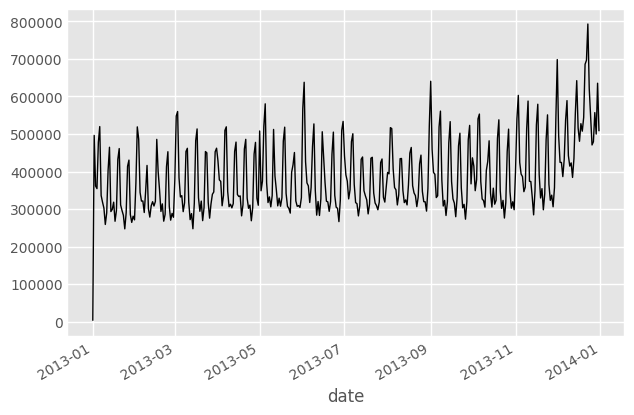

In [220]:
y_2013 = df[df.index.year == 2013]
y_2013.groupby(y_2013.index)['sales'].sum().plot(linewidth = 1, color = 'black')
plt.show()

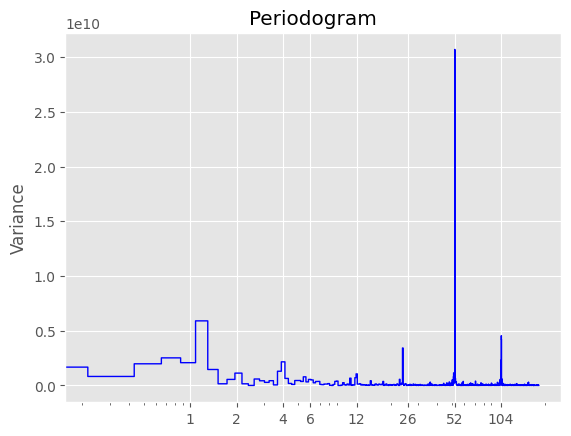

In [376]:
from scipy.signal import periodogram

daily_sales = df.groupby(df.index)['sales'].sum()

frequencies, spectrum = periodogram(
    daily_sales.values,
    fs = 365,   # 365/day sampling frequency
    detrend = 'linear',
    # window = "boxcar",
    # scaling = 'spectrum',
)


plt.step(frequencies, spectrum, color = "blue", linewidth = 1)
plt.xscale("log")
plt.xticks(
    [1, 2, 4, 6, 12, 26, 52, 104], # 52 is weekly it's not good for forier series
    [1, 2, 4, 6, 12, 26, 52, 104]
)
plt.ylabel("Variance")
plt.title("Periodogram")
plt.show()

In [282]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

#"YE",    Annual (yearly) seasonality
#"QE",    Quarterly seasonality
#"ME",    Monthly seasonality
#"W",    Weekly seasonality
#"D",    Daily seasonality

# based on our periodogram Q is the bestt
fourier = CalendarFourier(freq="QE", order=10)  # 10 sin/cos pairs for Quarterly seasonality

dp = DeterministicProcess(
    index = daily_sale.index,
    constant = True,               # dummy feature for bias (y-intercept)
    order = 1,                     # trend (order 1 means linear)
    seasonal = True,               # weekly seasonality (indicators)
    additional_terms = [fourier],  # auarterly seasonality (fourier)
    drop = True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

### Time Series as Features

The structure of these time series may not be apparent from a plot over time; however, some time series properties can only be modeled as **serially dependent (cycles)** properties, that is, using as features past values of the target series.

<br>

#### **Cycles**
Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but **not necessarily on the time step** itself. Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time.

> cyclic VS seasonality:<br>
cycles are not necessarily time dependent.<br>
cycle is less about the particular date of occurence, and more about what has happened in the recent past.<br>
cyclic behavior can be much more irregular

<br>

#### **Lagged Series and Lag Plots**
To investigate cycles, we need to create **lagged** copies of the series. infact, we shift its values forward/backward one or more time steps. The effect is that the observations in the lagged series will appear to have happened later in time.

> A **lag plot** of a time series shows its values plotted against its lags.

> The most commonly used measure of serial dependence is known as **autocorrelation**, which is simply the correlation a time series has with one of its lags.


#### **Choosing lags**
The partial autocorrelation tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak

> The correlogram is for lag features essentially what the periodogram is for Fourier features.

Autocorrelation and partial autocorrelation are measures of **linear dependence**. Because real-world time series often have substantial **non-linear dependences**, it's best to look at a lag plot when choosing lag features. The Sunspots series has lags with non-linear dependence which we might overlook with autocorrelation.

>  or use some more general measure of dependence, like [mutual information](https://www.kaggle.com/code/ryanholbrook/mutual-information)



In [85]:
def plot_lags(series, lags = 8):
    series = series.dropna()

    plt.figure(figsize=(15, 10))

    rows = 2
    cols = lags // 2 if lags % 2 == 0 else lags // 2 + 1

    for i, lag in enumerate(range(1, lags + 1)):
        plt.subplot(rows, cols, i + 1)

        # Create lagged series
        x_lag = series.shift(lag)

        # Calculate correlation
        corr = series.corr(x_lag)

        # Scatter plot
        plt.scatter(x_lag, series, alpha=0.5, s=10, color = 'blue')


        # Add regression line
        z = np.polyfit(x_lag.fillna(0.0), series, 1)
        p = np.poly1d(z)
        plt.plot(x_lag, p(x_lag), "r--", alpha=0.8, lw = 3)

        plt.title(f'Lag {lag} (corr: {corr:.2f})')
        plt.xlabel(f'Lagged {lag}')
        plt.ylabel('Original')

    plt.tight_layout()
    plt.show()

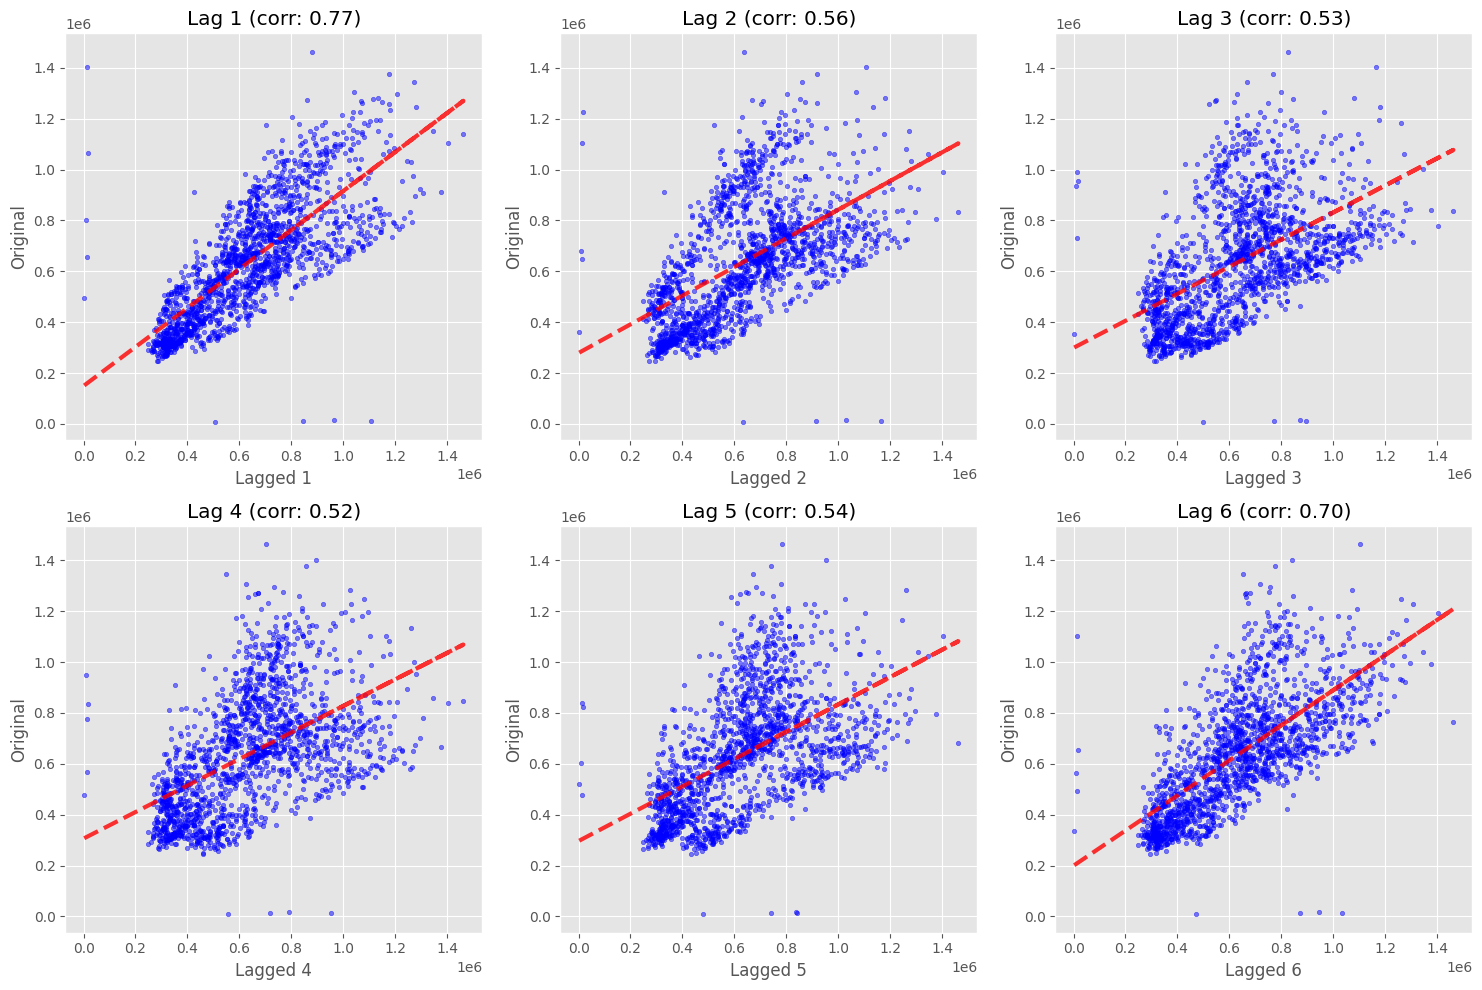

In [86]:
plot_lags(daily_sales, lags = 6)

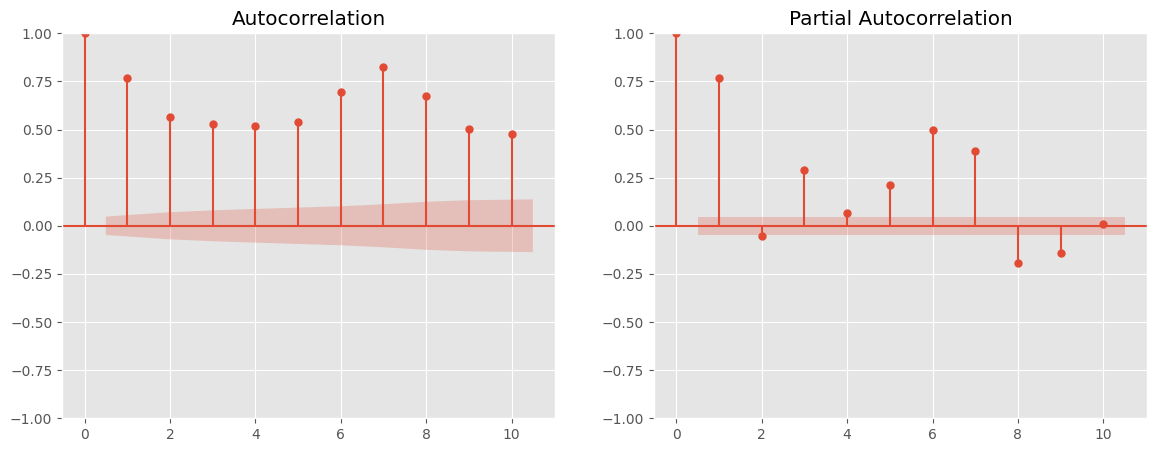

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_acf(daily_sales, lags=10, ax=plt.gca())

plt.subplot(1, 2, 2)
plot_pacf(daily_sales, lags=10, ax=plt.gca())


plt.show()

### Hybrid models

We want to combine learning algorithms and let the strengths of one make up for the weakness of the other

> **Linear regression** excels at extrapolating trends, but can't learn interactions (**Linear**).<br>
**XGBoost** excels at learning interactions, but can't extrapolate trends (**None-linear**).

three patterns of dependence: **trend, seasons, and cycles**, which called component of the time series.

> maybe you see somthing like this: Level + Trend + Seasonality + Noise. level is actually part of a trend, and this method missed cycles

```py
series = trend + seasons + cycles + error
```

#### **Residuals**
The difference between the target and the predictions (difference between the actual curve and the fitted curv)

#### **Error**
Learn the trend, seasonality, and cucles and subtract them out from the series separately, and finally only the unpredictable remains.

$\text{learn trend  from series} → residual: (series - trend) → \text{learn seasonality from residuals} → residual: (residual - sesonality) → ...$

### Two ways a regression algorithm can make predictions:

- **Feature-transforming algorithms** learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind.

- **Target-transforming algorithms** use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind.

> feature transformers generally can **extrapolate** target. <br>
target transformers' predictions always bound within the range of the training set

>  use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals.

> the method of using predictions as features is known as "stacking"

In [377]:
# First we use logistic regression to predict trend

df_daily_sum = df.groupby(df.index).agg(
    {
        'sales': 'sum',
        'store_nbr': 'sum',
        'onpromotion': 'count'
    }
)
df_daily_sum.columns = ['total_sales', 'total_store_nbr', 'num_onpromotion']
df_daily_sum.head(3)

,total_sales,total_store_nbr,num_onpromotion
date,,,
2013-01-01,2511.618999,49005,1782
2013-01-02,496092.417944,49005,1782
2013-01-03,361461.231124,49005,1782


In [569]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

y = df_daily_sum['total_sales'].copy()

fourier = CalendarFourier(freq = "QE", order=10)
# fourier_m = CalendarFourier(freq="ME", order=5)
# fourier_y = CalendarFourier(freq="YE", order=5)

dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order = 2,
    drop = True,
    # seasonal = True,
    additional_terms = [fourier]
    # additional_terms = [fourier, fourier_m, fourier_y]
)
# without fourier the trend that we will plot after linear regresion will be linear

X = dp.in_sample()
X.head()

,const,trend,trend_squared,"sin(1,freq=QE-DEC)","cos(1,freq=QE-DEC)","sin(2,freq=QE-DEC)","cos(2,freq=QE-DEC)","sin(3,freq=QE-DEC)","cos(3,freq=QE-DEC)","sin(4,freq=QE-DEC)",...,"sin(6,freq=QE-DEC)","cos(6,freq=QE-DEC)","sin(7,freq=QE-DEC)","cos(7,freq=QE-DEC)","sin(8,freq=QE-DEC)","cos(8,freq=QE-DEC)","sin(9,freq=QE-DEC)","cos(9,freq=QE-DEC)","sin(10,freq=QE-DEC)","cos(10,freq=QE-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,4.0,0.069756,0.997564,0.139173,0.990268,0.207912,0.978148,0.275637,...,0.406737,0.913545,0.469472,0.882948,0.529919,0.848048,0.587785,0.809017,0.642788,0.766044
2013-01-03,1.0,3.0,9.0,0.139173,0.990268,0.275637,0.961262,0.406737,0.913545,0.529919,...,0.743145,0.669131,0.829038,0.559193,0.898794,0.438371,0.951057,0.309017,0.984808,0.173648
2013-01-04,1.0,4.0,16.0,0.207912,0.978148,0.406737,0.913545,0.587785,0.809017,0.743145,...,0.951057,0.309017,0.994522,0.104528,0.994522,-0.104528,0.951057,-0.309017,0.866025,-0.500000
2013-01-05,1.0,5.0,25.0,0.275637,0.961262,0.529919,0.848048,0.743145,0.669131,0.898794,...,0.994522,-0.104528,0.927184,-0.374607,0.788011,-0.615661,0.587785,-0.809017,0.342020,-0.939693


In [570]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


train_idx, test_idx = train_test_split(y.index, test_size = 0.2, shuffle = False)

X_train, X_test = X.loc[train_idx, :], X.loc[test_idx, :]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

lr = LinearRegression(fit_intercept = False)
lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [571]:
y_train_trend = lr.predict(X_train)
y_test_trend = lr.predict(X_test)

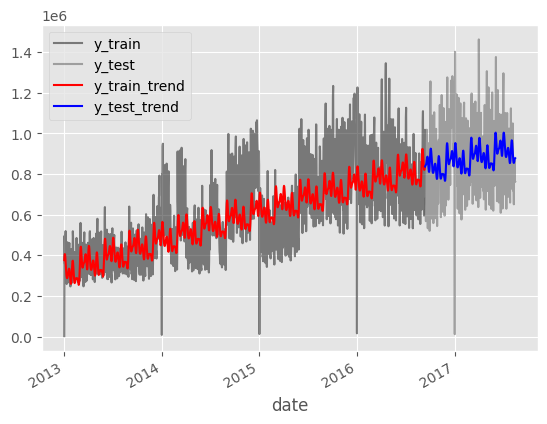

In [572]:
y_train.plot(color='0.05', alpha=0.5, label = 'y_train')
y_test.plot(color='0.35', alpha=0.5, label = 'y_test')

pd.Series(y_train_trend, index=y_train.index).plot(color = 'red', label = 'y_train_trend')
pd.Series(y_test_trend, index=y_test.index).plot(color = 'blue', label = 'y_test_trend')
plt.legend()
plt.show()

In [ ]:
residuals_train = y_train.values - y_train_trend

### Feature engineering
In time series, feature engineering means converting raw timestamps and signals into informative predictors that help models (like XGBoost, CatBoost, or Transformers) capture temporal patterns.

In [580]:
def create_time_features(df):
    """Create meaningful time-based features for XGBoost"""
    features = pd.DataFrame(index = df.index)

    # Basic time features
    features['day_of_week'] = df.index.dayofweek
    features['day_of_year'] = df.index.dayofyear
    features['day_of_month'] = df.index.day
    features['week_of_year'] = df.index.isocalendar().week
    features['month'] = df.index.month
    features['quarter'] = df.index.quarter
    features['year'] = df.index.year
    features['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    features['year'] = df.index.year
    features['is_month_end'] = df.index.is_month_end
    features['is_month_start'] = df.index.is_month_start

    # Cyclical encoding for periodic features
    features['day_of_week_sin'] = np.sin(2 * np.pi * features['day_of_week'] / 7)
    features['day_of_week_cos'] = np.cos(2 * np.pi * features['day_of_week'] / 7)
    features['month_sin'] = np.sin(2 * np.pi * features['month'] / 12)
    features['month_cos'] = np.cos(2 * np.pi * features['month'] / 12)
    features['sin_day'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
    features['cos_day'] = np.cos(2 * np.pi * df.index.dayofyear / 365)

    # # Add lag features for sales
    # for lag in [1, 2, 3, 7, 14]:  # Various time lags
    #     features[f'sales_lag_{lag}'] = df['total_sales'].shift(lag)

    # # Rolling statistics
    # features['rolling_mean_7'] = df['total_sales'].shift(1).rolling(7).mean()
    # features['rolling_std_7'] = df['total_sales'].shift(1).rolling(7).std()
    # features['sales_ratio_7'] = df['total_sales'] / (features['rolling_mean_7'] + 1e-6)


    return features

In [581]:
X_features = create_time_features(df_daily_sum)
X_train = X_features.loc[train_idx]
X_test = X_features.loc[test_idx]

In [582]:
from xgboost import XGBRegressor


xgb = XGBRegressor()
xgb.fit(X_train, residuals_train)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_train_trend
y_pred_boosted = xgb.predict(X_test) + y_test_trend

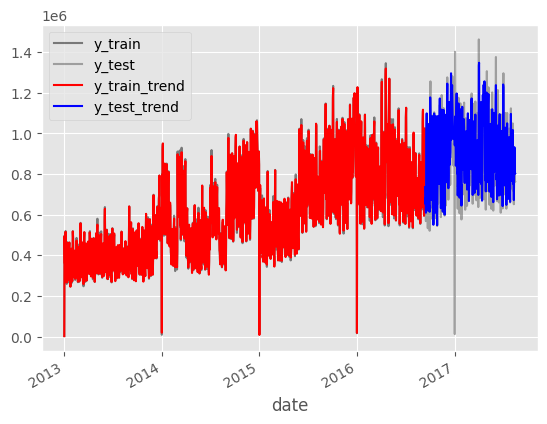

In [586]:
y_train.plot(color='0.05', alpha=0.5, label = 'y_train')
y_test.plot(color='0.35', alpha=0.5, label = 'y_test')

pd.Series(y_fit_boosted, index = y_train.index).plot(color = 'red', label = 'y_train_trend')
pd.Series(y_pred_boosted, index = y_test.index).plot(color = 'blue', label = 'y_test_trend')
plt.legend()
plt.show()

MAE: 61481.32,
RMSE: 9900448450.95


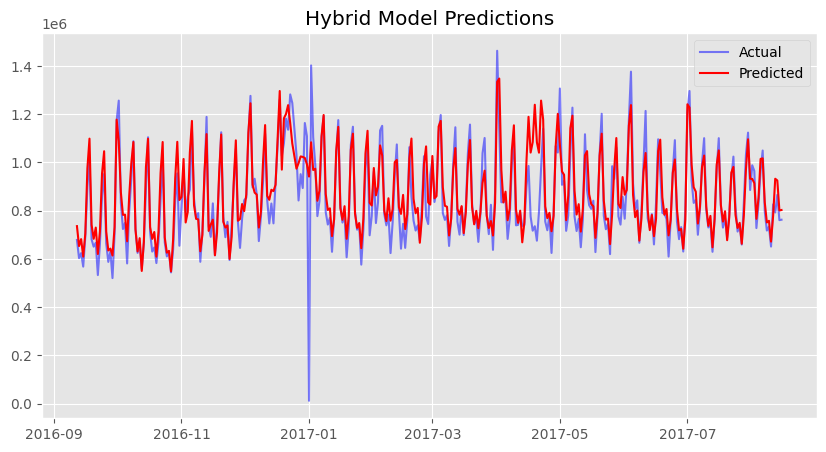

In [584]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_boosted)
rmse = mean_squared_error(y_test, y_pred_boosted)
print(f"MAE: {mae:.2f},\nRMSE: {rmse:.2f}")

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color = 'blue', alpha = 0.5)
plt.plot(y_test.index, y_pred_boosted, label="Predicted", color="red")
plt.legend()
plt.title("Hybrid Model Predictions")
plt.show()